# Redes neuronales profundas
## Global
- Carlos Moreno: 47840
- Lautaro Fernandez: 48534

## Colab things

In [1]:
import kagglehub

path = kagglehub.dataset_download("okarif/carla-parired-images")

print("Path to dataset files:", path)

100%|██████████| 4.07G/4.07G [03:31<00:00, 20.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/okarif/carla-parired-images/versions/3


In [2]:
!cp -r /root/.cache/kagglehub/datasets/okarif/carla-parired-images/versions/3/data_carla /content/data_carla

### Imports

In [3]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn

## Dataset

### Normalizacion
Obtener media y desviacion estandar para normalizar

In [4]:
# def get_mean_and_std(img_dir):
#     img_list = os.listdir(img_dir + '/day_train/')
#     mean = 0.0
#     std = 0.0
#     for img_name in img_list:
#         img_tensor = read_image(img_dir + '/day_train/' + img_name)
#         img_tensor = img_tensor.float()[:3]
#         mean += img_tensor.mean(dim=(1,2))
#         std += img_tensor.std(dim=(1,2))
#     mean /= len(img_list)
#     std /= len(img_list)
#     return mean, std

In [5]:
# mean, std = get_mean_and_std('data_carla')

### Dataset

In [6]:
class CarlaDataSet(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, train=True):
        self.day_folder = img_dir + '/day_train/' if train else img_dir + '/day_val/'
        self.night_folder = img_dir + '/night_train/' if train else img_dir + '/night_val/'
        self.img_labels = self.build_data_table()
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def build_data_table(self):
        data_table = pd.DataFrame(columns=['image', 'target'])
        data_table['image'] = [self.day_folder+img for img in os.listdir(self.day_folder) ]
        data_table['target'] = [self.night_folder+img for img in os.listdir(self.night_folder) ]
        return data_table

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        lbl_path = self.img_labels.iloc[idx, 1]
        # generates 4 channels because the image is in RGBA format (png)
        image = read_image(img_path)[:3]
        label = read_image(lbl_path)[:3]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label



In [7]:
SIZE_IMAGES = (224, 224)

transformations = transforms.Compose([
    transforms.Resize(SIZE_IMAGES),
    transforms.Lambda(lambda x: x / 255.0),  # Scale to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transformations_labels = transforms.Compose([
    transforms.Resize(SIZE_IMAGES),
    transforms.Lambda(lambda x: x / 255.0)  # Scale to [0, 1]
])

def get_datasets(img_dir):
  return (CarlaDataSet(img_dir, transform=transformations, target_transform=transformations_labels, train=True),
          CarlaDataSet(img_dir, transform=transformations, target_transform=transformations_labels, train=False))

def get_data_iters(dataset_train, dataset_test):
  return DataLoader(dataset_train, batch_size=50, shuffle=True), DataLoader(dataset_test, batch_size=50, shuffle=True)

### Muestreo

In [8]:
def show_sample(dataset:CarlaDataSet,sample: int):
  img = Image.open(dataset.img_labels.iloc[sample, 0])
  target = Image.open(dataset.img_labels.iloc[sample, 1])

  print('sample: ', sample)

  _, axes = plt.subplots(1, 2)

  axes[0].imshow(img)
  axes[0].set_title('Image')
  axes[1].imshow(target)
  axes[1].set_title('Target')

  for ax in axes:
    ax.axis('off')

  plt.show()

In [9]:
dataset_train, dataset_val = get_datasets('data_carla')
data_train, data_val = get_data_iters(dataset_train, dataset_val)

sample:  856


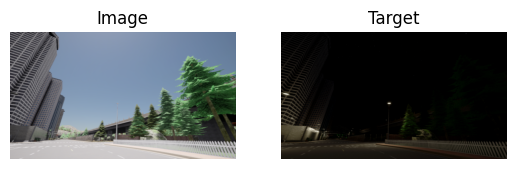

In [10]:
sample = random.randint(0, len(dataset_train))
show_sample(dataset_train,sample)

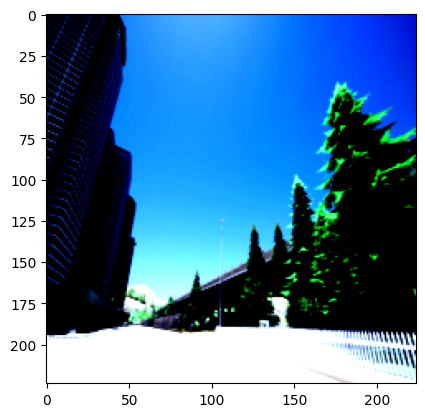

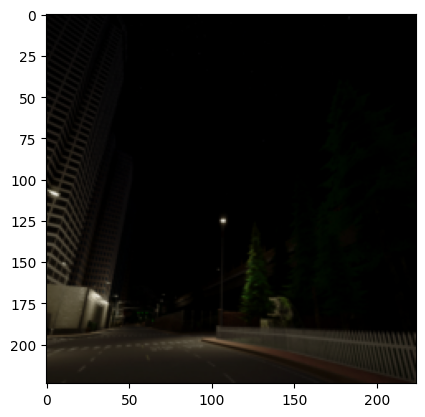

torch.Size([3, 224, 224])
tensor(-2.1179) tensor(2.0823)


In [11]:
# code to show a rgb image of the dataset using dataset_train[sample]

def plot_tensor(tensor: torch.Tensor):
  tensor = tensor.permute(1, 2, 0)
  plt.imshow(tensor)
  plt.show()

plot_tensor(dataset_train[sample][0])
plot_tensor(dataset_train[sample][1])
print(dataset_train[sample][0].shape)
print(dataset_train[sample][0].min(), dataset_train[sample][0].max())

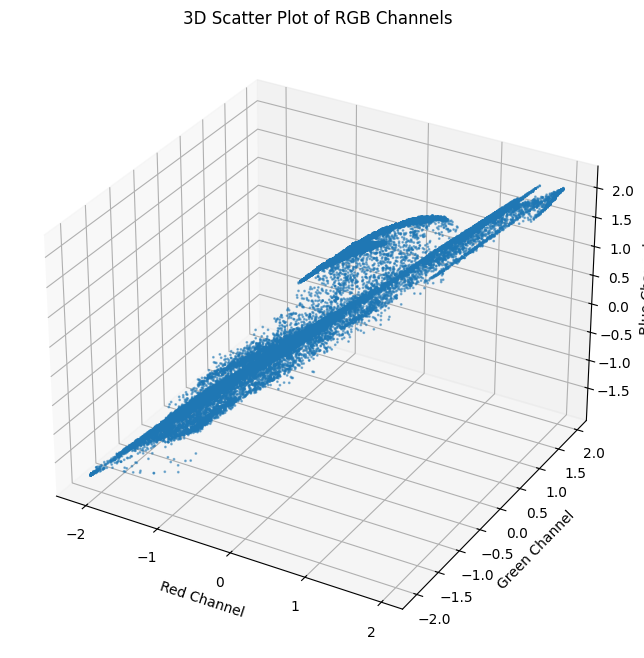

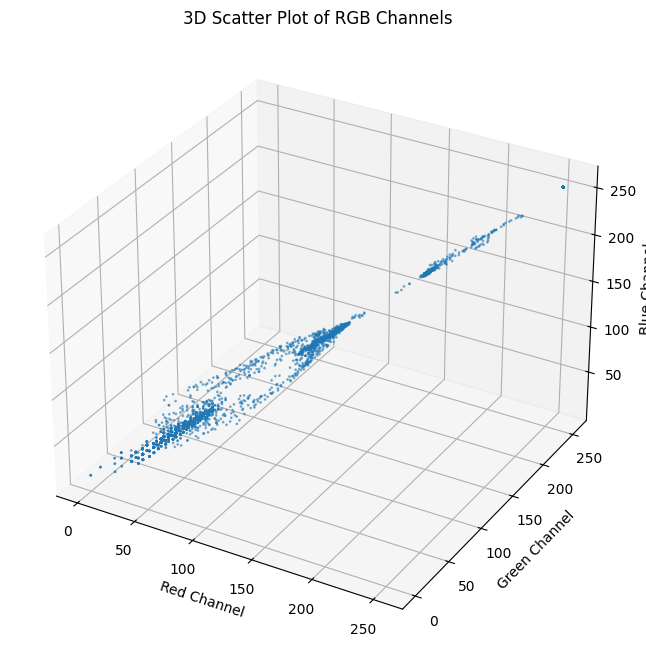

In [12]:
def scatter_plot_three_channels(rgb_image):
    """
    Create a 3D scatter plot of the RGB channels of an image.

    Parameters:
    - rgb_image: A tensor or NumPy array of shape (C, H, W) or (H, W, C).
    """

    if isinstance(rgb_image, torch.Tensor):
        rgb_image = rgb_image.numpy()
        if rgb_image.shape[0] == 3:
            rgb_image = np.transpose(rgb_image, (1, 2, 0))  # Convert to (H, W, C)

    # Flatten the channels
    r_values = rgb_image[..., 0].flatten()  # Red channel
    g_values = rgb_image[..., 1].flatten()  # Green channel
    b_values = rgb_image[..., 2].flatten()  # Blue channel

    # Create 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(r_values, g_values, b_values, alpha=0.5, s=1)  # Set size of points to 1 for clarity

    ax.set_title('3D Scatter Plot of RGB Channels')
    ax.set_xlabel('Red Channel')
    ax.set_ylabel('Green Channel')
    ax.set_zlabel('Blue Channel')

    plt.show()

# Example usage
scatter_plot_three_channels(dataset_train[sample][0])
scatter_plot_three_channels(read_image(dataset_train.img_labels.iloc[sample, 0]))


# Model

We gonna build up a U-Net using a pretrained resnet18 as encoder :)

In [13]:
# resnet18 = torchvision.models.resnet18(pretrained=True)
# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18

In [14]:
# for i,layer in enumerate(list(resnet18.children())[:-2]):
#   print('=======================================')
#   print('BLOCK', i)
#   print(layer)

In [15]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    # Iterate over in_channels and out_channels to assign the filter
    for i in range(in_channels):
        for j in range(out_channels):
            if i == j and i < min(in_channels, out_channels):  # Assign only if i == j and within bounds
                weight[i, j, :, :] = filt
    return weight

In [16]:
class ResNetEncoder(nn.Module):
    def __init__(self):
        super(ResNetEncoder, self).__init__()
        self.resnet = resnet18
        self.encoder_layers = list(self.resnet.children())[:-2]  # no avgpool nor fc
        self.encoder_block0 = nn.Sequential(*self.encoder_layers[:4])  # kind of init
        self.encoder_block1 = self.encoder_layers[4]
        self.encoder_block2 = self.encoder_layers[5]
        self.encoder_block3 = self.encoder_layers[6]
        self.encoder_block4 = self.encoder_layers[7]

    def forward(self, x):
        # print('gradients: ',torch.is_grad_enabled())
        x0 = self.encoder_block0(x)
        x1 = self.encoder_block1(x0)
        x2 = self.encoder_block2(x1)
        x3 = self.encoder_block3(x2)
        x4 = self.encoder_block4(x3)
        return x0, x1, x2, x3, x4

class ResNetDecoder(nn.Module):
    def __init__(self):
        super(ResNetDecoder, self).__init__()
        def _upconv_block(in_channels, out_channels):
            w = bilinear_kernel(in_channels, out_channels, 3)
            conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
            conv_transpose.weight.data.copy_(w)
            conv_transpose.bias.data.zero_()
            return nn.Sequential(
                conv_transpose,
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        # decoder
        self.upconv4 = _upconv_block(512, 256)
        self.upconv3 = _upconv_block(512, 128)
        self.upconv2 = _upconv_block(256, 64)
        self.upconv1 = _upconv_block(128, 64)

        # x0 must match d1 shape
        self.upconv0 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)

        # final upconv
        self.upconv = _upconv_block(128, 64)

    def forward(self, X):
        # print('gradients: ',torch.is_grad_enabled())
        x0, x1, x2, x3, x4 = X
        d4 = self.upconv4(x4)
        d3 = self.upconv3(torch.cat((d4,x3),dim=1))
        d2 = self.upconv2(torch.cat((d3,x2),dim=1))
        d1 = self.upconv1(torch.cat((d2,x1),dim=1))
        x0_up = self.upconv0(x0)
        d0 = self.upconv(torch.cat((d1,x0_up), dim=1))
        return d0


In [17]:
class ResNetUNet(nn.Module):
    def __init__(self):
        super(ResNetUNet, self).__init__()
        self.encoder = ResNetEncoder()
        self.decoder = ResNetDecoder()
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)
        # print('encoder output')
        # for i in x:
        #     print(i.shape)
        x = self.decoder(x)
        # print('decoder output')
        # print(x.shape)
        x = self.final_conv(x)
        # print('final output')
        # print(x.shape)
        return x

In [18]:
# net = ResNetUNet()
# net(dataset_train[sample][0].unsqueeze(0)).shape

In [19]:
torch.cuda.is_available()

True

In [20]:
def train(model, train_data, val_data, epochs=10, lr=0.001):
    model.to('cuda')
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        params=[{
            "params":[*model.decoder.parameters(), *model.final_conv.parameters()],
            "lr":lr
          },
          {
              "params":model.encoder.parameters(),
              "lr":lr*0.01
          }], lr=lr)
    for epoch in range(epochs):
        model.train()
        for i, (x, y) in enumerate(train_data):
            x = x.type(torch.float32).to('cuda')
            y = y.type(torch.float32).to('cuda')
            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            print(f'Epoch {epoch}, iter {i}, loss: {loss.item()}')
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for i, (x, y) in enumerate(val_data):
                x = x.to('cuda')
                y = y.to('cuda')
                y_hat = model(x)
                val_loss += criterion(y_hat, y)
            print(f'Epoch {epoch}, val_loss: {val_loss.item()}')

# train(net, data_train, data_val, epochs=25, lr=0.003)

In [21]:
# torch.save(net.state_dict(), 'model.pt')

# # To download the saved model file in Google Colab
# from google.colab import files
# files.download('model.pt')

# net.load_state_dict(torch.load('model_25_normalized.pt'))

In [22]:
# Pick a random element of the validation dataset and send it to the network
# net.to('cuda')
# net.eval()
# val_sample = random.randint(0, len(dataset_val))
# x = dataset_val[val_sample][0]
# x = x.unsqueeze(0).to('cuda')
# y = dataset_val[val_sample][1].unsqueeze(0).to('cuda')
# y_hat = net(x)
# plot_tensor(x[0].detach().cpu())
# plot_tensor(y_hat[0].detach().cpu())
# plot_tensor(y[0].detach().cpu())

## 2nd option: resnet 50

In [23]:
resnet50 = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


In [24]:
for i,layer in enumerate(list(resnet50.children())):
  print('=======================================')
  print('BLOCK', i)
  print(layer)

BLOCK 0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BLOCK 1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BLOCK 2
ReLU(inplace=True)
BLOCK 3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BLOCK 4
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256,

In [25]:
class ResNetEncoder50(nn.Module):
    def __init__(self):
        super(ResNetEncoder50, self).__init__()
        self.resnet = resnet50
        self.encoder_layers = list(self.resnet.children())[:-2]  # no avgpool nor fc
        self.encoder_block0 = nn.Sequential(*self.encoder_layers[:4])  # kind of init
        self.encoder_block1 = self.encoder_layers[4]
        self.encoder_block2 = self.encoder_layers[5]
        self.encoder_block3 = self.encoder_layers[6]
        self.encoder_block4 = self.encoder_layers[7]

    def forward(self, x):
        x0 = self.encoder_block0(x)
        x1 = self.encoder_block1(x0)
        x2 = self.encoder_block2(x1)
        x3 = self.encoder_block3(x2)
        x4 = self.encoder_block4(x3)
        return x, x0, x1, x2, x3, x4

class ResNetDecoder50(nn.Module):
    def __init__(self):
        super(ResNetDecoder50, self).__init__()

        def _upconv_block(in_channels, out_channels):
            w = bilinear_kernel(in_channels, out_channels, 3)
            conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
            conv_transpose.weight.data.copy_(w)
            conv_transpose.bias.data.zero_()
            return nn.Sequential(
                conv_transpose,
                nn.BatchNorm2d(out_channels),
                nn.Conv2d(out_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        # decoder
        self.upconv4 = _upconv_block(2048, 1024)
        self.upconv3 = _upconv_block(2048, 512)
        self.upconv2 = _upconv_block(1024, 256)
        self.upconv1 = _upconv_block(512, 64)
        # x0 must match d1 shape
        self.upconv0 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        # final upconv
        self.upconv = _upconv_block(128, 64)
    def forward(self, X):
        x, x0, x1, x2, x3, x4 = X
        d4 = self.upconv4(x4)
        d3 = self.upconv3(torch.cat((d4,x3),dim=1))
        d2 = self.upconv2(torch.cat((d3,x2),dim=1))
        d1 = self.upconv1(torch.cat((d2,x1),dim=1))
        x0_up = self.upconv0(x0)
        d0 = self.upconv(torch.cat((d1,x0_up), dim=1))
        return d0


In [26]:
class ResNetUNet50(nn.Module):
    def __init__(self):
        super(ResNetUNet50, self).__init__()
        self.encoder = ResNetEncoder50()
        self.decoder = ResNetDecoder50()
        self.final_conv = nn.Sequential(
          nn.Conv2d(67, 32, kernel_size=1),
          nn.Conv2d(32, 3, kernel_size=1)
          )

    def forward(self, x):
        x_encoder = self.encoder(x)
        x = self.decoder(x_encoder)
        x = self.final_conv(torch.cat((x_encoder[0], x), dim=1))
        return x

In [35]:
net = ResNetUNet50()

net.load_state_dict(torch.load('model_50_res_30.pt'))
# net.load_state_dict(torch.load('model_20.pt'))
train(net, data_train, data_val, epochs=10, lr=0.003)

torch.save(net.state_dict(), 'model_50_res_45.pt')

from google.colab import files
files.download('model_50_res_45.pt')

<ipython-input-35-bad800b612b8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('model_50_res_30.pt'))


Epoch 0, iter 0, loss: 0.0013592339819297194
Epoch 0, iter 1, loss: 0.0023073500487953424
Epoch 0, iter 2, loss: 0.002329717157408595
Epoch 0, iter 3, loss: 0.0013054830487817526
Epoch 0, iter 4, loss: 0.0019088058033958077
Epoch 0, iter 5, loss: 0.0021694451570510864
Epoch 0, iter 6, loss: 0.0016453452408313751
Epoch 0, iter 7, loss: 0.0016735043609514832
Epoch 0, iter 8, loss: 0.0016949609853327274
Epoch 0, iter 9, loss: 0.0016529966378584504
Epoch 0, iter 10, loss: 0.0017736749723553658
Epoch 0, iter 11, loss: 0.0022836963180452585
Epoch 0, iter 12, loss: 0.001684443443082273
Epoch 0, iter 13, loss: 0.002325547393411398
Epoch 0, iter 14, loss: 0.0020286466460675
Epoch 0, iter 15, loss: 0.0018451057840138674
Epoch 0, iter 16, loss: 0.0015775780193507671
Epoch 0, iter 17, loss: 0.0015112990513443947
Epoch 0, iter 18, loss: 0.0015932857058942318
Epoch 0, iter 19, loss: 0.0018716241465881467
Epoch 0, val_loss: 0.015556326135993004
Epoch 1, iter 0, loss: 0.001845265389420092
Epoch 1, ite

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

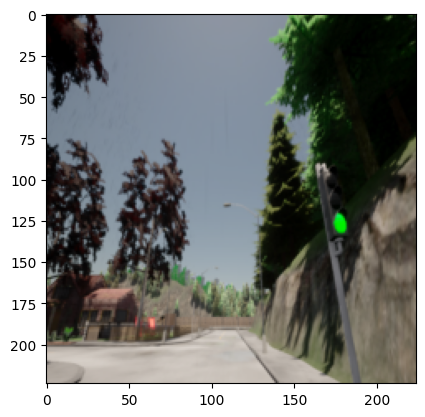

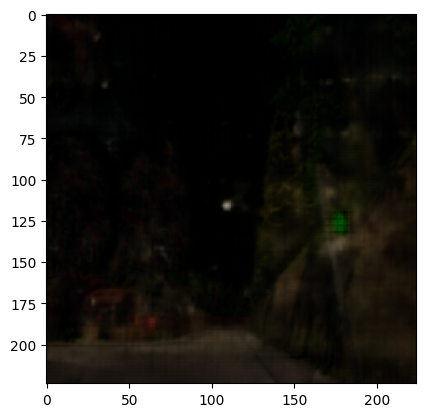

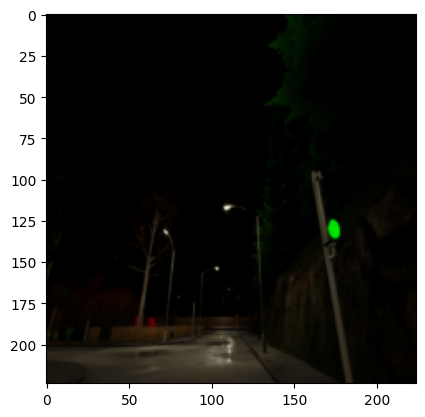

In [38]:
def desnormalize(tensor):
  tensor = tensor.to('cuda')
  mean = torch.tensor([0.485, 0.456, 0.406], device='cuda:0').view(3, 1, 1)
  std = torch.tensor([0.229, 0.224, 0.225], device='cuda:0').view(3, 1, 1)
  output_tensor = tensor * std + mean
  output_tensor = torch.clamp(output_tensor, 0, 1)
  output_tensor = (output_tensor * 255).byte()
  return output_tensor

net.to('cuda')
net.eval()
val_sample = random.randint(0, len(dataset_val))
x = dataset_val[val_sample][0]
x = x.unsqueeze(0).to('cuda')
y = dataset_val[val_sample][1].unsqueeze(0).to('cuda')
y_hat = net(x)
x= desnormalize(x)
plot_tensor(x[0].detach().cpu())
plot_tensor(y_hat[0].detach().cpu())
plot_tensor(y[0].detach().cpu())

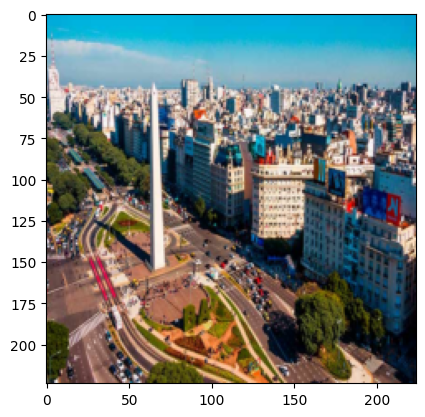

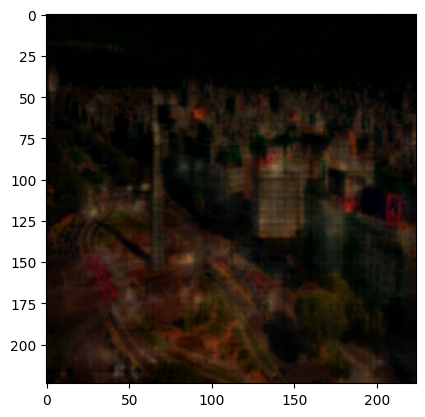

In [42]:
img = read_image('buenos_aires.jpg')

img = transformations(img)

img = img.unsqueeze(0).to('cuda')

img_hat = net(img)

img = desnormalize(img)

plot_tensor(img[0].detach().cpu())
plot_tensor(img_hat[0].detach().cpu())